In [1]:
from scipy.ndimage import gaussian_filter1d
import numpy as np
import matplotlib.pyplot as plt
from discretizer import Discretizer
from a_star import A_Star

In [2]:
class Translator():
    def __init__(self, track, world_size):
        self.track = track
        self.world_size = world_size

        

In [3]:
def checkNeighbours(x, y, map, surrounding):
    neighbours = [[x,y]]
    for i in range(1, surrounding+1):
        new_neighbours = []
        for (x,y) in neighbours:
            moves = [[0,i], [0,-i], [i, 0], [-i,0], [i,i], [i,-i], [-i,i], [-i,-i]]
            tmp = [[x,y]]*len(moves)
            possible_neighbours = [[x1+x2, y1+y2] for ((x1,y1),(x2,y2)) in zip(tmp, moves)]
        
            for (x_n, y_n) in possible_neighbours:
                if ((x_n>0) & (x_n<=map.shape[0]) & (y_n>0) & (y_n<=map.shape[0])):
                    if [x_n,y_n] not in neighbours:
                        new_neighbours.append([x_n, y_n])
            
        neighbours.extend(new_neighbours)

    return neighbours


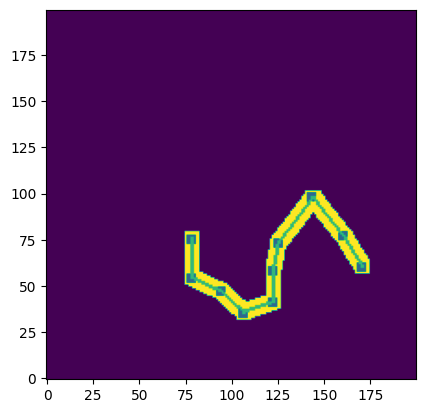

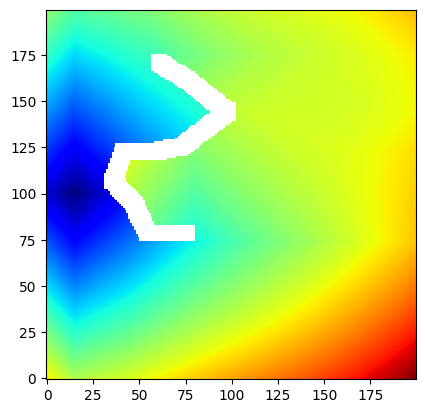

In [4]:
world_coords=[200,200]
landmarks = np.loadtxt("landmarks.csv", delimiter=",")
discretizer = Discretizer(landmarks, world_coords=world_coords)
discretizer.createMap()


for y, row in enumerate(discretizer.world_map):
    for x, pixel in enumerate(row):
        if pixel == 2:
            neighbours = checkNeighbours(x,y,discretizer.world_map,surrounding=2)
            for (x_n,y_n) in neighbours:
                if discretizer.world_map[y_n][x_n] == 0:
                    discretizer.world_map[y_n][x_n] = 3


plt.imshow(discretizer.world_map.transpose(1,0), origin="lower")

a_star = A_Star([100,15], [150,150], discretizer.world_map)
path = a_star.find_path()
plt.figure('Cost map')
d=a_star.d[1:world_coords[1]+1,1:world_coords[0]+1]
plt.imshow(d,cmap='jet', origin="lower")


In [11]:
def plan_line(start, end):
    distance = (np.sqrt((start[0] - end[0])**2 + (start[1]-end[1])**2))
    angle = np.arctan2(end[1]-start[1], end[0]-start[0])
    hit_obstacle = False
    return distance, angle, hit_obstacle

def plan_trajectory(path, map, num_ankers):
    ankers = np.linspace(0,len(path[0])-1,num_ankers,dtype="int64")
    trajectory = []
    last_angle = 0
    for i, anker in enumerate(ankers):
        if i == len(ankers)-1:
            break
        start = [path[0][anker], path[1][anker]]
        end = [path[0][ankers[i+1]], path[1][ankers[i+1]]]
        
        lenght, angle, hit_obstacle = plan_line(start, end)
        angle = angle - last_angle
        last_angle += angle
        trajectory.append([start, end, lenght, angle])

    return trajectory

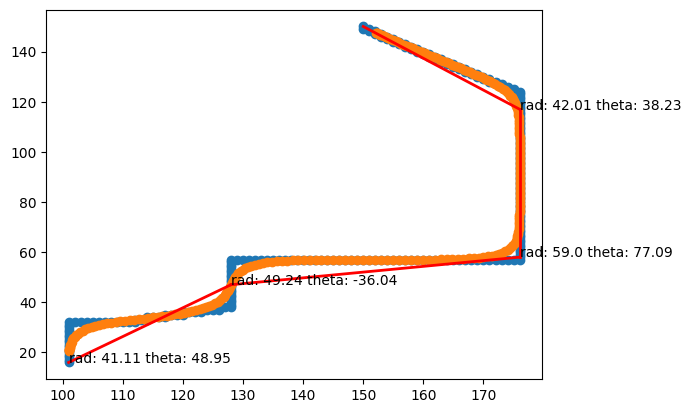

In [12]:
import cmath
n_moves = 5
trajectory = plan_trajectory(path, discretizer.world_map, n_moves)

x,y = path[0], path[1]

t = np.linspace(0, 1, len(x))
t2 = np.linspace(0, 1, 100)

x2 = np.interp(t2, t, x)
y2 = np.interp(t2, t, y)
sigma = 10
x3 = gaussian_filter1d(x2, sigma)
y3 = gaussian_filter1d(y2, sigma)

x4 = np.interp(t, t2, x3)
y4 = np.interp(t, t2, y3)

plt.plot(x, y, "o-", lw=2)
plt.plot(x3, y3, "r", lw=2)
plt.plot(x4, y4, "o", lw=2)
for move in trajectory:
    plt.plot([move[0][0], move[1][0]], [move[0][1], move[1][1]], color="red", lw=2)
    plt.annotate(f"rad: {np.round(move[2],2)} theta: {np.round(np.degrees(move[3]),2)}", move[0])
    
plt.show()

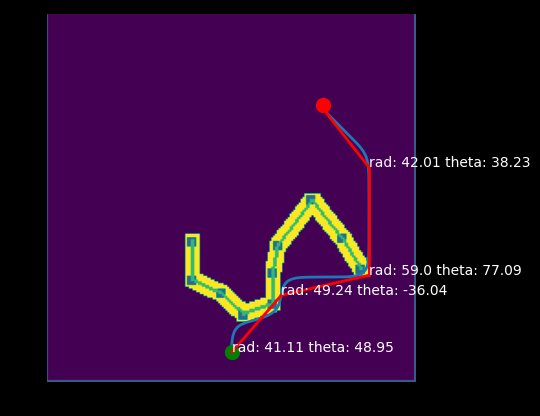

In [13]:
# plot shortest path
plt.figure('Shortest path', facecolor="black")
# plt.plot(path[0],path[1])
plt.plot(x4, y4, lw=2)
plt.plot(a_star.start[0]+1,a_star.start[1]+1,'g.',markersize=20)
plt.plot(a_star.goal[0]+1,a_star.goal[1]+1,'r.',markersize=20)
plt.imshow(a_star.world_map.transpose(1,0), origin="lower")
for move in trajectory:
    plt.plot([move[0][0], move[1][0]], [move[0][1], move[1][1]], color="red", lw=2)
    plt.annotate(f"rad: {np.round(move[2],2)} theta: {np.round(np.degrees(move[3]),2)}", move[0], c="w")

plt.show()